<a href="https://colab.research.google.com/github/Sharath-11507563/Aspect-based-sentimental-analysis-on-Rulemaking-comments/blob/main/Final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
import nltk, re, string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import seaborn as sn

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Importing Data

In [3]:
url = 'https://raw.githubusercontent.com/Sharath-11507563/Aspect-based-sentimental-analysis-on-Rulemaking-comments/main/Data_with_aspects.csv'
data = pd.read_csv(url)

In [4]:
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,Positive,Positive
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,Positive,Positive
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,Neutral,Positive
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,Positive,Positive
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,Positive,Neutral


Identifying index of the aspect

In [5]:
def find_index(comment, aspect):
  aspect_list = aspect.split(",")
  for aspect_ in aspect_list:
    if aspect_.lower() in comment.lower():
      index_ = comment.lower().find(aspect_)
      if index_ == -1: return str(len(comment)-len(aspect_))+"-"+str(len(comment))
      else: return str(index_)+"-"+str(index_+len(aspect_))

#Pre-processing the data

In [6]:
#Defining functions for pre-processing
stopwords_list = stopwords.words('english') # importing stopwords
punctuations_list = string.punctuation # get punctuations
lemmatizer = WordNetLemmatizer() # initialize word lemmatizer

def filter_annotation(annotator):
  (annotator1, annotator2, annotator3) = annotator
  if annotator1.lower()[:3]=='pos' and annotator2.lower()[:3]=='pos' and annotator3.lower()[:3]=='pos': return "Positive"
  elif annotator1.lower()[:3]=='neg' and annotator2.lower()[:3]=='neg' and annotator3.lower()[:3]=='neg': return "Negative"
  elif annotator1.lower()[:3]=='neu' and annotator2.lower()[:3]=='neu' and annotator3.lower()[:3]=='neu': return "Neutral"
  elif (annotator1.lower()[:3]=='pos' and annotator2.lower()[:3]=='pos') or  (annotator2.lower()[:3]=='pos' and annotator3.lower()[:3]=='pos') or (annotator3.lower()[:3]=='pos' and annotator1.lower()[:3]=='pos'): return "Positive"
  elif (annotator1.lower()[:3]=='neg' and annotator2.lower()[:3]=='neg') or (annotator2.lower()[:3]=='neg' and annotator3.lower()[:3]=='neg') or (annotator3.lower()[:3]=='neg' and annotator1.lower()[:3]=='neg'): return "Negative"
  elif (annotator1.lower()[:3]=='neu' and annotator2.lower()[:3]=='neu') or (annotator2.lower()[:3]=='neu' and annotator3.lower()[:3]=='neu') or (annotator3.lower()[:3]=='neu' and annotator1.lower()[:3]=='neu'): return "Neutral"
  else: return 'Neutral'

def preprocessing(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower())
    text = text + " ".join(emoticons).replace('-', '')
    tokenize_text = [lemmatizer.lemmatize(word) for word in nltk.tokenize.word_tokenize(text) 
                     if (word not in stopwords_list) and (word not in punctuations_list) and (len(word)>=2) and (word.isalpha())]
    return " ".join(tokenize_text)

In [7]:
#Applying above defined functions to the dataframe
data["Comment"] = data["Comment"].apply(str)
data["Clean_Comment"] = data["Comment"].apply(preprocessing)
data["Aspect Index"] = data[['Comment','Aspect']].apply(lambda x: find_index(*x), axis=1)
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3,Clean_Comment,Aspect Index
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,Positive,Positive,urging support fda support effort protecting c...,81-105
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,Positive,Positive,family smoking prevention tobacco control act ...,92-95
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,Neutral,Positive,director state tobacco control program would s...,158-175
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,Positive,Positive,please protection health welfare child free to...,54-62
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,Positive,Neutral,cigar little cigar pipe tobacco hook young peo...,49-61


Converting sentiment into a numeric

In [8]:
annotator = list(zip(data["Annotator 1"], data["Annotator 2"], data["Annotator 3"]))
data["Annotator"] = list(map(filter_annotation, annotator))

In [9]:
def absolute_sentiment(sentiment):
  if sentiment=="Positive": return 1
  elif sentiment=="Negative": return -1
  else: return 0
  
data['Triple_Sentiment'] = data['Annotator'].apply(absolute_sentiment)
data['Annotator_1'] = data['Annotator 1'].apply(absolute_sentiment)
data['Annotator_2'] = data['Annotator 2'].apply(absolute_sentiment)
data['Annotator_3'] = data['Annotator 3'].apply(absolute_sentiment)
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3,Clean_Comment,Aspect Index,Annotator,Triple_Sentiment,Annotator_1,Annotator_2,Annotator_3
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,Positive,Positive,urging support fda support effort protecting c...,81-105,Positive,1,1,1,1
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,Positive,Positive,family smoking prevention tobacco control act ...,92-95,Positive,1,1,1,1
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,Neutral,Positive,director state tobacco control program would s...,158-175,Positive,1,1,0,1
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,Positive,Positive,please protection health welfare child free to...,54-62,Positive,1,1,1,1
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,Positive,Neutral,cigar little cigar pipe tobacco hook young peo...,49-61,Positive,1,1,1,0


# Exploratory Data Analysis

Calculating Kappa values between three annotators

In [10]:
cohen_kappa_score(data['Annotator_1'],data['Annotator_2'])

0.8621215855766469

In [11]:
cohen_kappa_score(data['Annotator_2'],data['Annotator_3'])

0.7180684771554484

In [12]:
cohen_kappa_score(data['Annotator_1'],data['Annotator_3'])

0.8549604212049456

Finding out the skewness of the data annotation

Text(0.5, 1.0, 'Annotator 1')

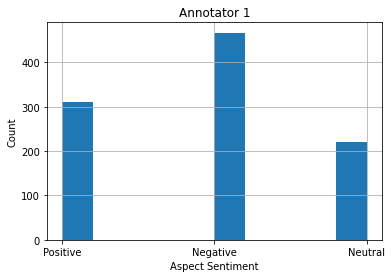

In [13]:
data['Annotator 1'].hist()
plot.xlabel('Aspect Sentiment')
plot.ylabel('Count')
plot.title('Annotator 1')

Text(0.5, 1.0, 'Annotator 2')

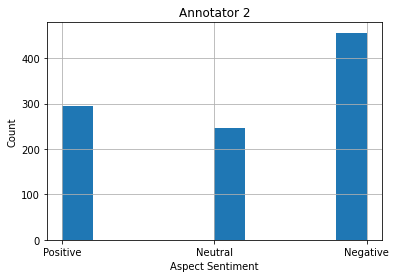

In [14]:
data['Annotator 2'].hist()
plot.xlabel('Aspect Sentiment')
plot.ylabel('Count')
plot.title('Annotator 2')

Text(0.5, 1.0, 'Annotator 3')

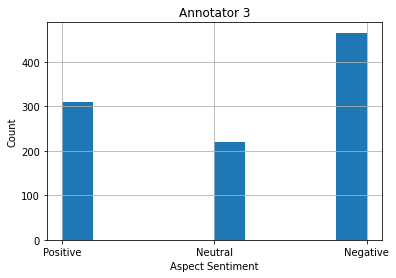

In [15]:
data['Annotator 3'].hist()
plot.xlabel('Aspect Sentiment')
plot.ylabel('Count')
plot.title('Annotator 3')

Text(0.5, 1.0, 'Triple Annotation')

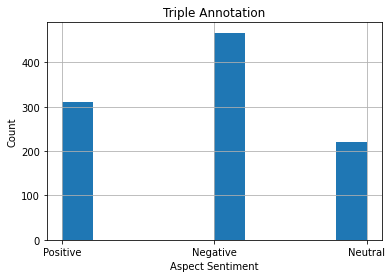

In [16]:
data['Annotator'].hist()
plot.xlabel('Aspect Sentiment')
plot.ylabel('Count')
plot.title('Triple Annotation')

Checking the most repeated aspects

In [17]:
freq= data['Aspect'].value_counts()
display(freq)

warnings                 27
warning labels           26
children                 23
small business           20
bladder cancer           14
                         ..
life saving tool          1
discouraging, warning     1
graphic, cartoon          1
physical education        1
tighter regulations       1
Name: Aspect, Length: 629, dtype: int64

Basic EDA for text data

In [18]:
data['Number of Sentences'] = data['Comment'].apply(lambda x: len(str(x).split(".")))
data['Number of Words'] = data['Comment'].apply(lambda x: len(str(x).split(" ")))
data['Number of Characters'] = data['Comment'].str.len()
def avg_word_length(sentence):
  words = sentence.split()
  if len(words) != 0:
    return(sum(len(word) for word in words)/len(words))
  else:
    return None
data['Average Word Length'] = data['Comment'].apply(lambda x: avg_word_length(x))
stop = stopwords.words('english')
data['Number of Stopwords'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x in stop]))
data['Number of numerics'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data['Number of upper case words'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3,Clean_Comment,Aspect Index,Annotator,Triple_Sentiment,Annotator_1,Annotator_2,Annotator_3,Number of Sentences,Number of Words,Number of Characters,Average Word Length,Number of Stopwords,Number of numerics,Number of upper case words
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,Positive,Positive,urging support fda support effort protecting c...,81-105,Positive,1,1,1,1,5,75,459,5.133333,32,0,4
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,Positive,Positive,family smoking prevention tobacco control act ...,92-95,Positive,1,1,1,1,6,142,908,5.401408,46,3,3
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,Neutral,Positive,director state tobacco control program would s...,158-175,Positive,1,1,0,1,4,75,495,5.613333,25,0,1
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,Positive,Positive,please protection health welfare child free to...,54-62,Positive,1,1,1,1,4,61,359,4.901639,23,0,2
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,Positive,Neutral,cigar little cigar pipe tobacco hook young peo...,49-61,Positive,1,1,1,0,3,26,178,5.884615,10,0,1


Summarising the results of basic EDA

In [19]:
print('The maximum,mimimum and average Number of sentences are',data['Number of Sentences'].max(),',',data['Number of Sentences'].min(),',',data['Number of Sentences'].mean())
print('The maximum,minimum and average Number of Words are',data['Number of Words'].max(),',',data['Number of Words'].min(),',',data['Number of Words'].mean())
print('The maximum,mimimum and average Number of Characters are',data['Number of Characters'].max(),',',data['Number of Characters'].min(),',',data['Number of Characters'].mean())
print('The maximum,mimimum and average of Average Word Length are',data['Average Word Length'].max(),',',data['Average Word Length'].min(),',',data['Average Word Length'].mean())
print('The maximum,mimimum and average Number of Stopwords are',data['Number of Stopwords'].max(),',',data['Number of Stopwords'].min(),',',data['Number of Stopwords'].mean())
print('The maximum,mimimum and average Number of numerics are',data['Number of numerics'].max(),',',data['Number of numerics'].min(),',',data['Number of numerics'].mean())
print('The maximum,mimimum and average Number of upper case words are',data['Number of upper case words'].max(),',',data['Number of upper case words'].min(),',',data['Number of upper case words'].mean())

The maximum,mimimum and average Number of sentences are 111 , 1 , 9.435871743486974
The maximum,minimum and average Number of Words are 899 , 3 , 148.84068136272546
The maximum,mimimum and average Number of Characters are 5042 , 13 , 904.5821643286573
The maximum,mimimum and average of Average Word Length are 14.2 , 2.5 , 5.012063117688139
The maximum,mimimum and average Number of Stopwords are 386 , 0 , 58.90480961923848
The maximum,mimimum and average Number of numerics are 11 , 0 , 0.6863727454909819
The maximum,mimimum and average Number of upper case words are 226 , 0 , 5.214428857715431


#Building models for Triple annotation dataset

In [20]:
comment = data["Aspect"]
sentiment = data["Triple_Sentiment"]

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)

Accuracy:  0.54
Navie Bayes accuracy on train data:  79 %
Navie Bayes accuracy on test data:  54 %
              precision    recall  f1-score   support

          -1       0.79      0.64      0.71       172
           0       0.09      0.25      0.13        24
           1       0.49      0.44      0.46       104

    accuracy                           0.54       300
   macro avg       0.46      0.44      0.43       300
weighted avg       0.63      0.54      0.58       300

The Average Accuracy score for a ten-fold cross-validations is: 53.303030303030305 %


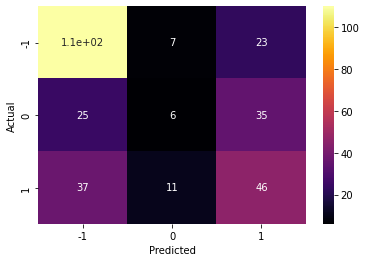

In [22]:
nb_pipeline = Pipeline([('CV', CountVectorizer()), ('model', MultinomialNB()),])
nb_pipeline.fit(X_train,Y_train)

Y_pred = nb_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
print("Navie Bayes accuracy on train data: ", round(nb_pipeline.score(X_train,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(nb_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(nb_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

SVM accuracy on train data:  83 %
SVM accuracy on test data:  52 %
              precision    recall  f1-score   support

          -1       0.74      0.63      0.68       164
           0       0.14      0.28      0.18        32
           1       0.48      0.43      0.45       104

    accuracy                           0.52       300
   macro avg       0.45      0.45      0.44       300
weighted avg       0.58      0.52      0.55       300

The Average Accuracy score for a ten-fold cross-validations is: 50.70202020202019 %


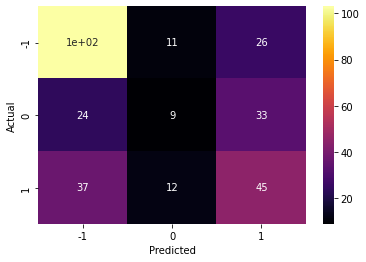

In [23]:
svm_pipeline = Pipeline([('CV', CountVectorizer()),('model', SGDClassifier()),])
svm_pipeline.fit(X_train,Y_train)

Y_pred = svm_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SVM accuracy on train data: ", round(svm_pipeline.score(X_train,Y_train)*100), '%')
print("SVM accuracy on test data: ", round(svm_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(svm_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

Decision Tree accuracy on train data:  86 %
Decision Tree accuracy on test data:  52 %
              precision    recall  f1-score   support

          -1       0.79      0.61      0.69       180
           0       0.21      0.30      0.25        47
           1       0.33      0.42      0.37        73

    accuracy                           0.52       300
   macro avg       0.44      0.44      0.44       300
weighted avg       0.58      0.52      0.54       300

The Average Accuracy score for a ten-fold cross-validations is: 51.596969696969694 %


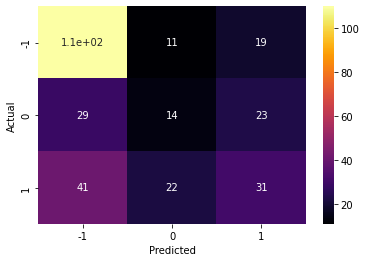

In [24]:
DT_pipeline = Pipeline([('CV', CountVectorizer()),('model', DecisionTreeClassifier()),])
DT_pipeline.fit(X_train,Y_train)

Y_pred = DT_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_pipeline.score(X_train,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(DT_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

Random Forest accuracy on train data:  86 %
Random Forest accuracy on test data:  53 %
              precision    recall  f1-score   support

          -1       0.79      0.61      0.69       179
           0       0.21      0.33      0.26        43
           1       0.36      0.44      0.40        78

    accuracy                           0.53       300
   macro avg       0.45      0.46      0.45       300
weighted avg       0.59      0.53      0.55       300

The Average Accuracy score for a ten-fold cross-validations is: 51.90404040404041 %


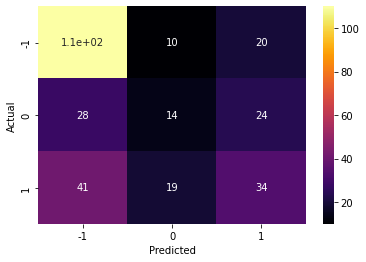

In [25]:
RF_pipeline = Pipeline([('CV', CountVectorizer()),('model', RandomForestClassifier()),])
RF_pipeline.fit(X_train,Y_train)

Y_pred = RF_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(RF_pipeline.score(X_train,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(RF_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(RF_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

Logestic Regression accuracy on train data:  77 %
Logestic Regression accuracy on test data:  55 %
              precision    recall  f1-score   support

          -1       0.81      0.62      0.70       185
           0       0.14      0.47      0.21        19
           1       0.46      0.45      0.45        96

    accuracy                           0.55       300
   macro avg       0.47      0.51      0.46       300
weighted avg       0.66      0.55      0.59       300

The Average Accuracy score for a ten-fold cross-validations is: 53.3060606060606 %


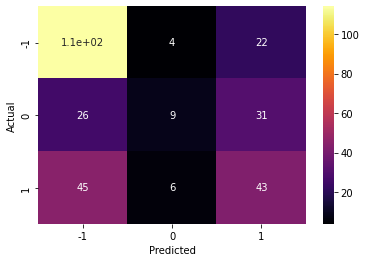

In [26]:
LR_pipeline = Pipeline([('CV', CountVectorizer()),('model', LogisticRegression()),])
LR_pipeline.fit(X_train,Y_train)

Y_pred = LR_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logestic Regression accuracy on train data: ", round(LR_pipeline.score(X_train,Y_train)*100), '%')
print("Logestic Regression accuracy on test data: ", round(LR_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(LR_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

#Building models for Single annotation dataset

In [27]:
comment = data["Clean_Comment"]
sentiment = data["Annotator_1"]

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True,stratify=sentiment)

Navie Bayes accuracy on train data:  84 %
Navie Bayes accuracy on test data:  65 %
              precision    recall  f1-score   support

          -1       0.79      0.74      0.76       149
           0       0.29      0.59      0.39        32
           1       0.71      0.56      0.63       119

    accuracy                           0.65       300
   macro avg       0.60      0.63      0.59       300
weighted avg       0.70      0.65      0.67       300

The Average Accuracy score for a ten-fold cross-validations is: 62.13838383838384 %


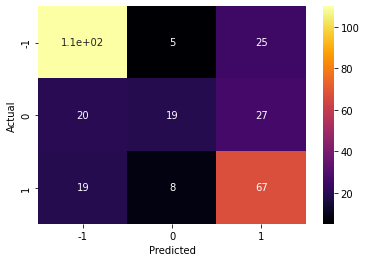

In [29]:
nb_pipeline = Pipeline([('CV', CountVectorizer()), ('model', MultinomialNB()),])
nb_pipeline.fit(X_train,Y_train)

Y_pred = nb_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Navie Bayes accuracy on train data: ", round(nb_pipeline.score(X_train,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(nb_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(nb_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

SVM accuracy on train data:  98 %
SVM accuracy on test data:  60 %
              precision    recall  f1-score   support

          -1       0.66      0.76      0.71       122
           0       0.30      0.38      0.34        52
           1       0.71      0.53      0.61       126

    accuracy                           0.60       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.62      0.60      0.60       300

The Average Accuracy score for a ten-fold cross-validations is: 54.636363636363626 %


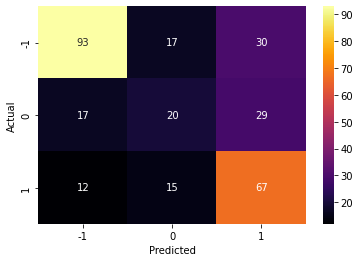

In [30]:
svm_pipeline = Pipeline([('CV', CountVectorizer()),('model', SGDClassifier()),])
svm_pipeline.fit(X_train,Y_train)

Y_pred = svm_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SVM accuracy on train data: ", round(svm_pipeline.score(X_train,Y_train)*100), '%')
print("SVM accuracy on test data: ", round(svm_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(svm_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

Decision Tree accuracy on train data:  100 %
Decision Tree accuracy on test data:  56 %
              precision    recall  f1-score   support

          -1       0.66      0.74      0.70       126
           0       0.36      0.34      0.35        71
           1       0.54      0.50      0.52       103

    accuracy                           0.56       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.55      0.56      0.55       300

The Average Accuracy score for a ten-fold cross-validations is: 53.01616161616162 %


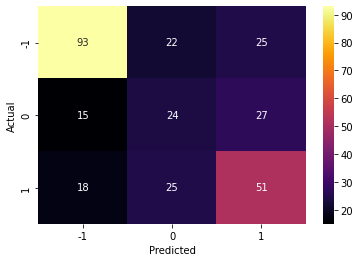

In [31]:
DT_pipeline = Pipeline([('CV', CountVectorizer()),('model', DecisionTreeClassifier()),])
DT_pipeline.fit(X_train,Y_train)

Y_pred = DT_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_pipeline.score(X_train,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(DT_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

Random Forest accuracy on train data:  100 %
Random Forest accuracy on test data:  62 %
              precision    recall  f1-score   support

          -1       0.78      0.70      0.74       156
           0       0.23      0.58      0.33        26
           1       0.65      0.52      0.58       118

    accuracy                           0.62       300
   macro avg       0.55      0.60      0.55       300
weighted avg       0.68      0.62      0.64       300

The Average Accuracy score for a ten-fold cross-validations is: 59.73232323232324 %


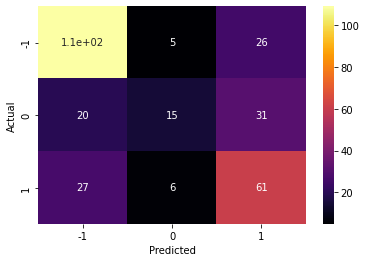

In [32]:
RF_pipeline = Pipeline([('CV', CountVectorizer()),('model', RandomForestClassifier()),])
RF_pipeline.fit(X_train,Y_train)

Y_pred = RF_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(RF_pipeline.score(X_train,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(RF_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(RF_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')

Logestic Regression accuracy on train data:  99 %
Logestic Regression accuracy on test data:  59 %
              precision    recall  f1-score   support

          -1       0.71      0.74      0.72       134
           0       0.30      0.43      0.36        46
           1       0.63      0.49      0.55       120

    accuracy                           0.59       300
   macro avg       0.55      0.56      0.54       300
weighted avg       0.61      0.59      0.60       300

The Average Accuracy score for a ten-fold cross-validations is: 57.134343434343435 %


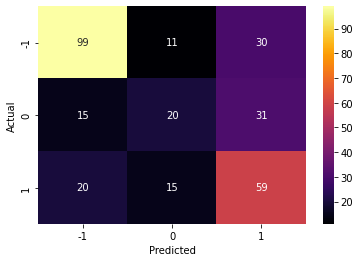

In [33]:
LR_pipeline = Pipeline([('CV', CountVectorizer()),('model', LogisticRegression(max_iter=1000)),])
LR_pipeline.fit(X_train,Y_train)

Y_pred = LR_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logestic Regression accuracy on train data: ", round(LR_pipeline.score(X_train,Y_train)*100), '%')
print("Logestic Regression accuracy on test data: ", round(LR_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(LR_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean()*100,'%')